In [1]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'semantic-segmentation-of-aerial-imagery:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F681625%2F1196732%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240307%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240307T170335Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D0a2a7bbf4694d9f761ae36ab9a9a48ad87937789ec01059a5fd93d2d67232c1ab326d2973e2391805c9717a3f2740fb2e81574c3773a4eda22e4e84749f2ffe95efdd39a956fda797f7a7d5bdab97a6859d30347a7d65ceb5124f2cae1ea28167138ce6b25ad9ebcb2eb624d8b75d7e9848fd59ced6e8969e247f5369e475b396de17545d6e0be6283d57d9bc37d7d6416646936acce138d5ef5066e8b3fba1869a6ba3fc86c78165e5886cdd2e1c6c91b1964215016a6c334f289b22d23fee0f5d0de2b842be1edea4ffb44dd45308372875d949a2b830980016de545ec9c9325ac4e9040911904b88b5d343a879de31e024476822e2dd3d790edf74b0b1f55'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 31045284 bytes downloaded
Downloaded and uncompressed: semantic-segmentation-of-aerial-imagery
Data source import complete.


In [2]:
pip install patchify

#### Importing Necessary Libraries

In [3]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import cv2
import matplotlib.pyplot as plt
from PIL import Image
from patchify import patchify
from sklearn.preprocessing import MinMaxScaler

#### Exploring the dataset

In [4]:
link = '/kaggle/input/semantic-segmentation-of-aerial-imagery/Semantic segmentation dataset'

In [5]:
for path, subdirs, file in os.walk(link):
    dir_names = path.split(os.path.sep)[-1]
    #print(dir_names)
    if dir_names == 'images':
        images = os.listdir(path)
        print(images)

['image_part_002.jpg', 'image_part_009.jpg', 'image_part_006.jpg', 'image_part_005.jpg', 'image_part_007.jpg', 'image_part_003.jpg', 'image_part_004.jpg', 'image_part_008.jpg', 'image_part_001.jpg']
['image_part_002.jpg', 'image_part_009.jpg', 'image_part_006.jpg', 'image_part_005.jpg', 'image_part_007.jpg', 'image_part_003.jpg', 'image_part_004.jpg', 'image_part_008.jpg', 'image_part_001.jpg']
['image_part_002.jpg', 'image_part_009.jpg', 'image_part_006.jpg', 'image_part_005.jpg', 'image_part_007.jpg', 'image_part_003.jpg', 'image_part_004.jpg', 'image_part_008.jpg', 'image_part_001.jpg']
['image_part_002.jpg', 'image_part_009.jpg', 'image_part_006.jpg', 'image_part_005.jpg', 'image_part_007.jpg', 'image_part_003.jpg', 'image_part_004.jpg', 'image_part_008.jpg', 'image_part_001.jpg']
['image_part_002.jpg', 'image_part_009.jpg', 'image_part_006.jpg', 'image_part_005.jpg', 'image_part_007.jpg', 'image_part_003.jpg', 'image_part_004.jpg', 'image_part_008.jpg', 'image_part_001.jpg']
['ima

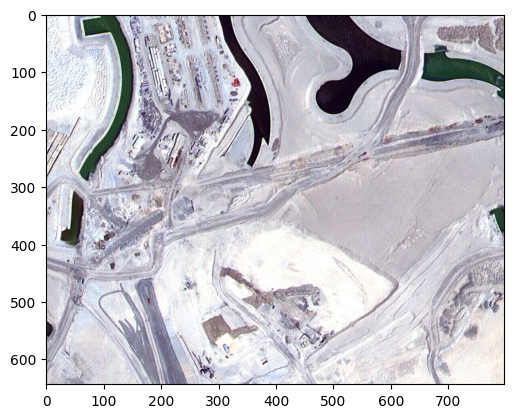

In [6]:
image_part_001 = cv2.imread(f'{link}/Tile 1/images/image_part_001.jpg',1)
image_part_001_rgb = cv2.cvtColor(image_part_001, cv2.COLOR_BGR2RGB)
plt.imshow(image_part_001_rgb)

This code reads the image with OpenCV, converts it from BGR to RGB (since OpenCV uses BGR by default, but matplotlib expects RGB), and then displays it using matplotlib.

#### patchify

In [7]:
patch_size = 256
scaler = MinMaxScaler()

In [13]:
def prepare_dataset(image_type, image_extension):
  dataset = []

  for tile_id in range(1,9):
    for image_id in range(1,10):
      image = cv2.imread(f'{link}/Tile {tile_id}/{image_type}/image_part_00{image_id}.{image_extension}',1)

      if image is not None:
        if image_type == 'masks':
          image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        #creating the row and column size for each image for patchifying
        size_x = (image.shape[1]//patch_size)*patch_size
        size_y= (image.shape[0]//patch_size)*patch_size

        image = Image.fromarray(image)
        image = image.crop((0,0,size_x,size_y))


        image = np.asarray(image)
        patched_images = patchify(image,(patch_size,patch_size,3), step = patch_size)

        for i in range(patched_images.shape[0]):
          for j in range(patched_images.shape[1]):
            if image_type == 'images':
              individual_image = patched_images[i,j,:,:]
              scaled_image = scaler.fit_transform(individual_image.reshape(-1,individual_image.shape[-1])).reshape(individual_image.shape)

              dataset.append(scaled_image[0])

            elif image_type == 'masks':
              individual_mask = patched_images[i,j,:,:]
              individual_mask = individual_mask[0]
              dataset.append(individual_mask)
  return dataset

In [14]:
image_dataset = prepare_dataset('images','jpg')
mask_dataset = prepare_dataset('masks', 'png')

In [15]:
print(len(image_dataset))
print(len(mask_dataset))

1305
1305


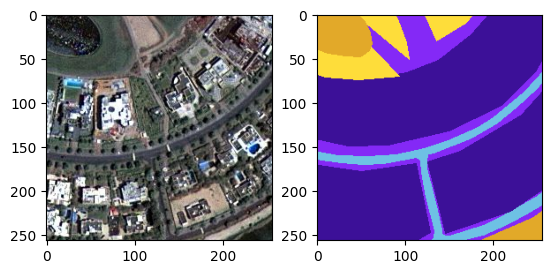

In [16]:
random_number = np.random.randint(0,len(image_dataset))
plt.subplot(121)
plt.imshow(image_dataset[random_number])
plt.subplot(122)
plt.imshow(mask_dataset[random_number])